## 🧪 Data Preparation and Model Setup

In this section, we import the necessary libraries for:
- Data manipulation
- Preprocessing and dimensionality reduction
- Handling imbalanced datasets
- Building and training a PyTorch model


In [34]:
# 📦 Importing libraries
import pandas as pd
import numpy as np

# ⚙️ Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report

# ⚖️ Handling class imbalance
from imblearn.over_sampling import SMOTE

# 🔥 PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


## 🔧 Load and Preprocess Data

In this step, we:
- Load the dataset from a CSV file
- Separate the features `X` and target variable `y`
- Encode the target labels if they are categorical


In [35]:
# 🔧 Load and preprocess data
df = pd.read_csv("Sleep Train 5000.csv")

# 📊 Features and target
X = df.drop(columns=[df.columns[0]])  # Drop first column (assumed to be the target)
y = df[df.columns[0]]                 # Target variable

# 🔠 Encode labels if they are categorical
if y.dtype == 'object':
    y = LabelEncoder().fit_transform(y)


## ⚖️ Handle Class Imbalance with SMOTE

To address potential class imbalance in the dataset, we use **SMOTE (Synthetic Minority Over-sampling Technique)**.  
This generates synthetic samples for the minority class to balance the dataset.


In [36]:
# Apply SMOTE for balancing
X_res, y_res = SMOTE().fit_resample(X, y)


## 🚦 Split Dataset into Training and Test Sets

We split the dataset into:
- **Training set** (80%)
- **Test set** (20%)

to evaluate model performance on unseen data.


In [37]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

## 📏 Feature Scaling

We scale the features using **StandardScaler** to ensure all features contribute equally to the model.  
This transforms the data to have zero mean and unit variance.

In [38]:
# Scale and reduce features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 🔥 Convert Data to PyTorch Tensors and Prepare DataLoader

- Convert NumPy arrays to PyTorch tensors for model training.
- Create a `TensorDataset` and a `DataLoader` for efficient batching and shuffling during training.


In [39]:
# Torch tensors
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)


## ✅ Improved MLP Model with GELU Activation and Xavier Weight Initialization

- A multi-layer perceptron with three hidden layers.
- Uses **Batch Normalization** and **Dropout** to improve training stability and reduce overfitting.
- Applies **GELU activation**, which often outperforms ReLU.
- Weights are initialized using **Xavier uniform initialization**.


In [40]:
# ✅ Improved MLP with GELU and weight init
class SuperMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SuperMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        self.init_weights()

    def init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

## ✅ Setup Device and Initialize Model

- Automatically use **GPU** if available, otherwise default to **CPU**.
- Instantiate the `SuperMLP` model with input dimension and number of output classes.
- Move the model to the selected device.


In [41]:
# ✅ Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SuperMLP(X_train_scaled.shape[1], len(np.unique(y))).to(device)

## ⚖️ Handle Class Imbalance with Class Weights and Setup Training Components

- Compute **class weights** to address imbalanced classes during loss calculation.
- Use **CrossEntropyLoss** with class weights.
- Set up **AdamW optimizer** for training.
- Use **Cosine Annealing LR scheduler** for learning rate adjustment.


In [42]:
# Class weights to handle imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3)

## 🔄 Training Loop with Early Stopping

- Train the model for up to 130 epochs.
- Track training loss and validation accuracy.
- Use early stopping to stop training if validation accuracy doesn’t improve for 10 consecutive epochs.
- Save the best model state during training.


Epoch 1, Loss: 1.2960, Train Acc: 0.4571, Val Acc: 0.5625
Epoch 2, Loss: 1.0503, Train Acc: 0.5720, Val Acc: 0.6500
Epoch 3, Loss: 0.9410, Train Acc: 0.6238, Val Acc: 0.6610
Epoch 4, Loss: 0.8596, Train Acc: 0.6601, Val Acc: 0.6990
Epoch 5, Loss: 0.7977, Train Acc: 0.6889, Val Acc: 0.7090
Epoch 6, Loss: 0.7536, Train Acc: 0.7100, Val Acc: 0.7145
Epoch 7, Loss: 0.7017, Train Acc: 0.7389, Val Acc: 0.7380
Epoch 8, Loss: 0.6618, Train Acc: 0.7506, Val Acc: 0.7465
Epoch 9, Loss: 0.6200, Train Acc: 0.7651, Val Acc: 0.7690
Epoch 10, Loss: 0.5879, Train Acc: 0.7804, Val Acc: 0.7630
Epoch 11, Loss: 0.5830, Train Acc: 0.7796, Val Acc: 0.7570
Epoch 12, Loss: 0.5194, Train Acc: 0.8077, Val Acc: 0.7835
Epoch 13, Loss: 0.5223, Train Acc: 0.8070, Val Acc: 0.7880
Epoch 14, Loss: 0.4884, Train Acc: 0.8174, Val Acc: 0.7850
Epoch 15, Loss: 0.4765, Train Acc: 0.8206, Val Acc: 0.7980
Epoch 16, Loss: 0.4680, Train Acc: 0.8259, Val Acc: 0.7940
Epoch 17, Loss: 0.4375, Train Acc: 0.8360, Val Acc: 0.8115
Epoch 

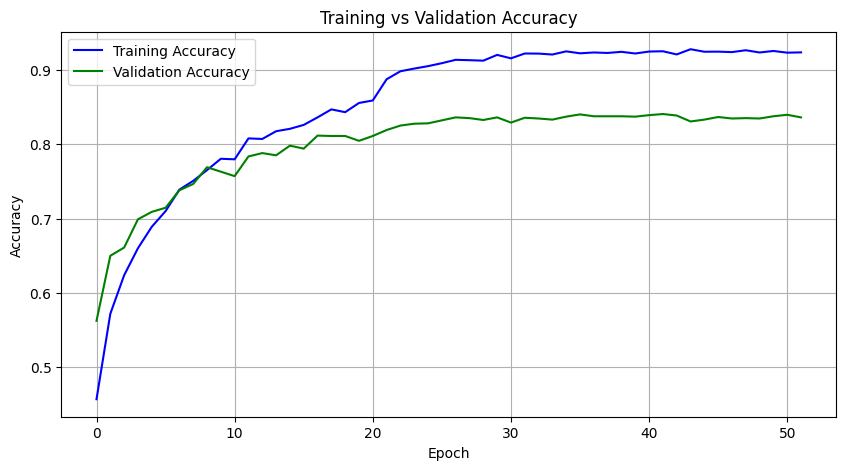

In [43]:
import matplotlib.pyplot as plt
# Initialize lists to store metrics
train_accuracies = []
val_accuracies = []

best_acc = 0
epochs_no_improve = 0

for epoch in range(130):
    model.train()
    running_loss = 0
    correct_train = 0
    total_train = 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(preds.data, 1)
        total_train += yb.size(0)
        correct_train += (predicted == yb).sum().item()

    # Calculate training accuracy
    train_acc = correct_train / total_train
    train_accuracies.append(train_acc)

    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor.to(device))
        val_pred_labels = torch.argmax(val_preds, dim=1).cpu().numpy()
        val_acc = accuracy_score(y_test, val_pred_labels)
        val_accuracies.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_dl):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        epochs_no_improve = 0
        best_model = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve == 10:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break

# Plot both accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 📊 Final Evaluation

- Load the best model saved during training.
- Evaluate on the test set.
- Calculate and print the **accuracy** and detailed **classification report**.


In [44]:
# ✅ Evaluation
model.load_state_dict(best_model)
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor.to(device))
    pred_labels = torch.argmax(preds, dim=1).cpu().numpy()

acc = accuracy_score(y_test, pred_labels)
print("\n📊 Final MLP Accuracy:", round(acc, 4))
print(classification_report(y_test, pred_labels))



📊 Final MLP Accuracy: 0.836
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       402
           1       0.84      0.89      0.86       406
           2       0.73      0.53      0.62       408
           3       0.82      0.89      0.85       401
           4       0.83      0.90      0.87       383

    accuracy                           0.84      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.83      0.84      0.83      2000

